In [ ]:
!pip install SDA

In [ ]:
!pip install nolds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
import os
import gc
from google.colab import drive
import pandas as pd
import numpy as np
import nolds
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats, signal
import glob
from tqdm import tqdm
from datetime import datetime, timedelta
import sys
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r "/content/drive/MyDrive/SDA" "/content/"

import sys
sys.path.append('/content/SDA')

from SDA import SDA

Mounted at /content/drive


## Чтение данных

In [ ]:
drive.mount('/content/drive')
directory_path = '/content/drive/MyDrive/1h'
pd.set_option('display.float_format', lambda x: '%.10f' % x)
FS = 50  # Частота дискретизации
WINDOW_SIZE_SEC = 10
output_file = 'all_stations_features.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_sorted_file_list(data_dir):
    all_files = os.listdir(directory_path)

    all_files.sort(key=lambda x: (
        re.split('_| ', x)[0] + '_' + re.split('_| ', x)[1],
        re.split('_| ', x)[2][0]
    ))
    return all_files

In [ ]:
def scale_dataframe(df, station_columns, multiplier=1e6):
    df_scaled = df.copy()
    for station in station_columns:
        if station in df.columns:
            data = df[station].values
            valid_mask = ~np.isnan(data)

            if np.any(valid_mask):
                df_scaled.loc[valid_mask, station] = data[valid_mask] * multiplier

    return df_scaled

In [ ]:
def extract_datetime_from_filename(file_name):
    pattern = r'(\d{4})-(\d{2})-(\d{2}) (\d{2})'

    match = re.search(pattern, file_name)
    if match:
        year, month, day, hour = map(int, match.groups())
        file_dt = datetime(year, month, day, hour)
        return file_dt

    print(f"Некрасивое имя: {file_name}")
    return None


## Метрики

In [ ]:
def calculate_features(data):

    features = {
        #'mean': np.mean(data),
        'median': np.median(np.abs(data)),
        'std': np.std(data),
        'min': np.min(data),
        'max': np.max(data),
        'range': np.ptp(data),  # max - min
        'rms': np.sqrt(np.mean(np.square(data))),
        'skewness': stats.skew(data),
        'kurtosis': stats.kurtosis(data)
    }
    return features

In [ ]:
def calculate_entropy_features(data):

    features = {}
    #try:
    features['sampen'] = nolds.sampen(data)
    #except:
        #features['sampen'] = np.nan
    return features

In [ ]:
def calculate_all_features(data_chunk):

    features = {}

    features.update(calculate_features(data_chunk))

    # Энтропийные метрики
    #features.update(calculate_entropy_features(data_chunk))

    return features

## Обработка данных

In [ ]:
def process_all_data(data_dir, output_file):

    all_files = get_sorted_file_list(data_dir)
    print(f"Найдено {len(all_files)} файлов ")

    window_samples = FS * WINDOW_SIZE_SEC
    all_features = []

    for i in tqdm(range(0, len(all_files), 3), desc="Обработка часовых интервалов"):
        if i + 2 >= len(all_files):
            break

        files_hour = all_files[i:i+3]

        base_datetime = extract_datetime_from_filename(files_hour[0])
        if base_datetime is None:
            continue

        component_files = {}
        for file_name in files_hour:
            if '_E.csv' in file_name:
                component_files['E'] = os.path.join(directory_path, file_name)
            elif '_N.csv' in file_name:
                component_files['N'] = os.path.join(directory_path, file_name)
            elif '_U.csv' in file_name:
                component_files['U'] = os.path.join(directory_path, file_name)

        try:
            df_e = pd.read_csv(component_files['E'])
            df_n = pd.read_csv(component_files['N'])
            df_u = pd.read_csv(component_files['U'])

            station_columns = [col for col in df_e.columns if col!= 'Unnamed: 0']

            df_e = scale_dataframe(df_e, station_columns)
            df_n = scale_dataframe(df_n, station_columns)
            df_u = scale_dataframe(df_u, station_columns)
        except Exception as e:
            print(f"Ошибка загрузки файлов: {e}")
            continue

        num_samples = min(len(df_e), len(df_n), len(df_u))
        num_windows = num_samples // window_samples

        for win in range(num_windows):

            start_idx = win * window_samples
            end_idx = start_idx + window_samples

            window_start_time = base_datetime + timedelta(seconds=win * WINDOW_SIZE_SEC)

            features_dict = {'datetime': window_start_time}

            for station in station_columns:
                for comp, df in zip(['E', 'N', 'U'], [df_e, df_n, df_u]):
                    if station in df.columns:
                        data = df[station].iloc[start_idx:end_idx].values

                        if len(data) < window_samples * 0.9 or np.all(np.isnan(data)):
                            continue

                        feats = calculate_all_features(data)
                        for feat_name, feat_value in feats.items():
                            col_name = f"{station}_{comp}_{feat_name}"
                            features_dict[col_name] = feat_value

            all_features.append(pd.DataFrame([features_dict]))

    if all_features:
        final_df = pd.concat(all_features, ignore_index=True)

        final_df = final_df.set_index('datetime')
        final_df.index = pd.to_datetime(final_df.index)

        final_df = final_df.sort_index()

        final_df.to_csv(output_file, index=True)
        print(f"Результаты в {output_file}")
        print(f"Размер итоговой таблицы: {final_df.shape}")
        print(f"Временной диапазон: {final_df.index.min()} - {final_df .index.max()}")
        return final_df
    else:
        print("Все плохо(")
        return None

In [ ]:
result_df = process_all_data(directory_path, output_file)
#result_df = pd.read_csv('all_stations_features.csv')
#result_df['datetime'] = pd.to_datetime(result_df['datetime'])
#result_df = result_df.set_index('datetime')

if result_df is not None:
    print(result_df.head())
    print("\nИнформация о данных:")
    print(result_df.info())

Найдено 144 файлов 


Обработка часовых интервалов: 100%|██████████| 48/48 [23:19<00:00, 29.17s/it]


Результаты в all_stations_features.csv
Размер итоговой таблицы: (17280, 312)
Временной диапазон: 2011-09-09 00:00:00 - 2011-09-10 23:59:50
                     E.HSDM_E_median  E.HSDM_E_std   E.HSDM_E_min  \
datetime                                                            
2011-09-09 00:00:00    10.0314378148 14.2355022643 -43.9415049933   
2011-09-09 00:00:10    10.2986660269 14.9561974600 -50.7858044175   
2011-09-09 00:00:20     9.6638213023 14.3989525523 -39.1089714041   
2011-09-09 00:00:30     9.9133092159 14.5574627595 -40.6768600797   
2011-09-09 00:00:40    10.3106508666 15.3438704356 -64.4171287937   

                     E.HSDM_E_max  E.HSDM_E_range  E.HSDM_E_rms  \
datetime                                                          
2011-09-09 00:00:00 43.6741188071   87.6156238004 14.7853757038   
2011-09-09 00:00:10 57.4486293637  108.2344337812 15.0234907987   
2011-09-09 00:00:20 48.2131207265   87.3220921306 14.9690144925   
2011-09-09 00:00:30 43.0798961583   83.756

## Объединение данных

In [ ]:
def smart_aggregate_station_metrics(metrics_df):
    result_df = pd.DataFrame()
    if 'datetime' in metrics_df.columns:
        result_df['datetime'] = metrics_df['datetime']

    aggregation_rules = {
        'median': 'mean',
        'rms': 'mean',
        'std': 'rms',
        'range': 'rms',
        'min': 'min',
        'max': 'max',
        'skewness': 'mean',
        'kurtosis': 'mean'
    }

    directions = ['E', 'N', 'U']
    for direction in directions:
        for metric_type, rule in aggregation_rules.items():
            pattern = f'_{direction}_{metric_type}'
            metric_cols = [col for col in metrics_df.columns if pattern in col]

            if rule == 'mean':
                result_df[f'avg_{direction}_{metric_type}'] = metrics_df[metric_cols].mean(axis=1)

            elif rule == 'rms':
                result_df[f'avg_{direction}_{metric_type}'] = np.sqrt(np.mean(np.square(metrics_df[metric_cols]), axis=1))

            elif rule == 'min':
                result_df[f'global_{direction}_min'] = metrics_df[metric_cols].min(axis=1)

            elif rule == 'max':
                result_df[f'global_{direction}_max'] = metrics_df[metric_cols].max(axis=1)

    return result_df

def calculate_spatial_statistics(metrics_df, result_df):

    for metric in ['median', 'std']:
        metric_cols = [col for col in metrics_df.columns if f'_{metric}' in col and 'datetime' not in col]
        if metric_cols:
            result_df[f'spatial_std_{metric}'] = metrics_df[metric_cols].std(axis=1)

    return result_df

# Основная функция обработки
def process_metrics_averaging(metrics_df):
    print(f"Исходный размер данных: {metrics_df.shape}")

    averaged_df = smart_aggregate_station_metrics(metrics_df)
    averaged_df = calculate_spatial_statistics(metrics_df, averaged_df)

    if metrics_df.index.name == "datetime":
        averaged_df["datetime"] = metrics_df.index

    print(f"Финальный размер данных: {averaged_df.shape}")

    output_file = 'averaged_metrics.csv'
    averaged_df.to_csv(output_file, index=False)
    print(f"Усредненные метрики в: {output_file}")

    return averaged_df

In [ ]:
averaged_metrics_df = process_metrics_averaging(result_df)
#averaged_metrics_df = pd.read_csv('averaged_metrics.csv')
#averaged_metrics_df['datetime'] = pd.to_datetime(averaged_metrics_df['datetime'])
#averaged_metrics_df = averaged_metrics_df.set_index('datetime')

print("\nПервые 5 строк усредненных данных:")
print(averaged_metrics_df.head())

print("\nКолонки в результате:")
for col in averaged_metrics_df.columns:
    print(f"  {col}")

Исходный размер данных: (17280, 312)
Финальный размер данных: (17280, 27)
Усредненные метрики в: averaged_metrics.csv

Первые 5 строк усредненных данных:
                     avg_E_median     avg_E_rms     avg_E_std    avg_E_range  \
datetime                                                                       
2011-09-09 00:00:00 10.5946259961 15.2901239917 15.1106663853  96.3726796335   
2011-09-09 00:00:10 11.4636485113 16.3451765015 16.7277220997 101.6351566304   
2011-09-09 00:00:20 10.8528835339 15.8162598361 16.0786356740  98.8579902356   
2011-09-09 00:00:30 11.2118542729 16.0804887636 15.9878563066  96.7445030567   
2011-09-09 00:00:40 10.4565415127 15.6654002762 15.5781012354 103.5468210804   

                       global_E_min   global_E_max  avg_E_skewness  \
datetime                                                             
2011-09-09 00:00:00  -98.3497535967  69.8887880699    0.0017605663   
2011-09-09 00:00:10  -89.4666098267  81.2271403427    0.0024265650   
2011-

## SDA

In [ ]:
SDA_PARAMS = dict(
    scale=False,
    verbose=True,
    n_clusters_min=2,
    n_clusters_max=6,
    k_neighbours_min=3,
    k_neighbours_max=10,
    st1_len_thresholds=[0, 5, 10, 20],
    st2_len_thresholds=[20]
)

In [ ]:
def run_sda_analysis(data, sda_params):

    scaler = StandardScaler()
    X = scaler.fit_transform(data)

    sda = SDA(**sda_params)
    res, edges_df = sda.apply(X)

    best_i = res["Avg-Silh"].idxmax()
    best = res.loc[best_i]
    print(f"\nBest segmentation: row {best_i} (Avg-Silh={best['Avg-Silh']:.3f})")


    return res, best, X, scaler

def visualize_results(data, best_result, X, scaler):
    raw = best_result["St_edges"]
    edges = list(raw) if not isinstance(raw, str) else [int(x) for x in raw.strip("[]").split()]

    timestamps = data.index
    n = len(timestamps)
    stage_ids = np.zeros(n, dtype=int)

    for sid, (start, stop) in enumerate(zip(edges[:-1], edges[1:])):
        stage_ids[max(0, start):min(stop, n)] = sid

    plt.figure(figsize=(15, 6))

    plt.subplot(2, 1, 1)
    plt.step(timestamps, stage_ids, where="post", lw=2, color='blue')
    plt.title(f'SDA Segmentation (Best Score: {best_result.get("Avg-Silh", best_result.get("Silh", 0)):.3f})')
    plt.ylabel('Stage ID')
    plt.ylim(-0.5, len(edges) - 0.5)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return stage_ids, edges

def analyze_segment_statistics(data, stage_ids):

    unique_stages = np.unique(stage_ids)
    stats = []

    for stage in unique_stages:
        mask = stage_ids == stage
        segment_data = data[mask]

        stats.append({
            'stage': stage,
            'duration_minutes': len(segment_data),
            'start_time': segment_data.index[0],
            'end_time': segment_data.index[-1],
            'mean_intensity': segment_data.mean().mean(),
            'max_intensity': segment_data.max().max(),
            'std_intensity': segment_data.std().mean()
        })

    stats_df = pd.DataFrame(stats)
    print(stats_df.to_string(index=False))

    return stats_df

In [ ]:
def analyze_best_sda_parameters(res, best):
    print("\n1. Лучшая комбинация:")
    print(f"   Строка в результатах: {best.name}")
    print(f"   N_stages: {best['N_stages']}")
    print(f"   Avg-Silh Score: {best['Avg-Silh']:.3f}")
    print(f"   Silhouette Score: {best['Silh']:.3f}")
    print(f"   Calinski-Harabasz: {best['Cal-Har']:.2f}")
    print(f"   Davies-Bouldin: {best['Dav-Bold']:.3f}")

    print("\n2. Топ-5 :")
    top_5 = res.nlargest(5, 'Avg-Silh')[['N_stages', 'Avg_stage_length', 'Avg-Silh']]
    print(top_5.round(3))

Applying to 2880 samples with 29 features each


stage 2: 100%|██████████| 672/672 [06:26<00:00,  1.74it/s]



Best segmentation: row 698 (Avg-Silh=0.345)


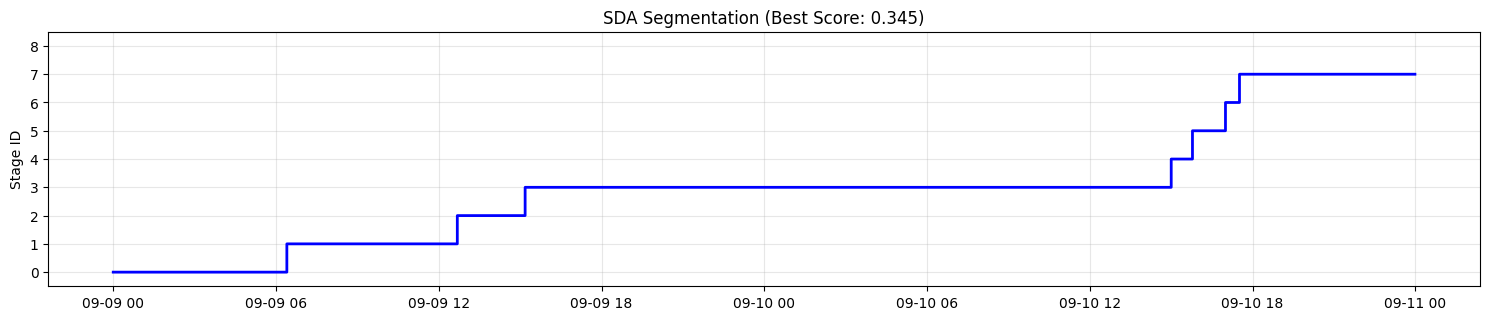

 stage  duration_minutes          start_time            end_time  mean_intensity    max_intensity   std_intensity
     0               384 2011-09-09 00:00:00 2011-09-09 06:23:00   31.2598276232  1577.5007699400   53.0539534185
     1               377 2011-09-09 06:24:00 2011-09-09 12:40:00   85.0388869821  7350.4665558800  160.1090595407
     2               150 2011-09-09 12:41:00 2011-09-09 15:10:00  174.9445524144  6307.5137810100  290.4365667753
     3              1429 2011-09-09 15:11:00 2011-09-10 14:59:00   56.2614416155 19139.0930425000  164.2293477796
     4                47 2011-09-10 15:00:00 2011-09-10 15:46:00  328.2468146070 67291.0758810881 2854.1461616201
     5                73 2011-09-10 15:47:00 2011-09-10 16:59:00   58.3505406292  1608.7281177600   63.5465103925
     6                31 2011-09-10 17:00:00 2011-09-10 17:30:00   50.2014980951  2788.9943365600   99.9828126550
     7               389 2011-09-10 17:31:00 2011-09-10 23:59:00   35.7550377167  4779.2

In [ ]:
processed_data = averaged_metrics_df
results, best_result, X_scaled, scaler = run_sda_analysis(processed_data, SDA_PARAMS)
stage_ids, edges = visualize_results(processed_data, best_result, X_scaled, scaler)
stats_df = analyze_segment_statistics(processed_data, stage_ids)

output_data = processed_data.copy()
output_data['stage_id'] = stage_ids
output_data['segment_boundary'] = False
valid_edges = [edge for edge in edges if edge < len(output_data)]
output_data.loc[output_data.index[valid_edges], 'segment_boundary'] = True

output_data.to_csv('sda_minute_analysis_results.csv')
stats_df.to_csv('segment_statistics.csv', index=False)

##SDA - 2

In [ ]:
def refine_segment(data, stage_ids, edges, target_stage, sda_params):

    # 1. Достаём подданные
    start_idx, end_idx = edges[target_stage], edges[target_stage+1]
    sub_data = data.iloc[start_idx:end_idx]

    # 2. Запускаем SDA на подотрезке
    scaler = StandardScaler()
    X_sub = scaler.fit_transform(sub_data)
    sda = SDA(**sda_params)
    res_sub, _ = sda.apply(X_sub)

    best_i = res_sub["Avg-Silh"].idxmax()
    best_sub = res_sub.loc[best_i]
    raw_sub = best_sub["St_edges"]
    sub_edges = list(raw_sub) if not isinstance(raw_sub, str) else [int(x) for x in raw_sub.strip("[]").split()]

    # 3. Пересчёт локальных границ в глобальные
    global_sub_edges = [start_idx + e for e in sub_edges]

    # 4. Формируем новые edges: до target_stage, его замена, после
    new_edges = edges[:target_stage] + global_sub_edges + edges[target_stage+2:]

    # 5. Пересчитываем stage_ids для новых сегментов
    n = len(data)
    new_stage_ids = np.zeros(n, dtype=int)
    for sid, (st, en) in enumerate(zip(new_edges[:-1], new_edges[1:])):
        new_stage_ids[st:en] = sid

    timestamps = data.index
    plt.figure(figsize=(15, 5))
    plt.step(timestamps, new_stage_ids, where="post", lw=2, color='green')
    plt.title("Refined SDA Segmentation")
    plt.ylabel("Stage ID")
    plt.xlabel("Time")
    plt.ylim(-0.5, len(new_edges) - 0.5)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return new_stage_ids, new_edges

Applying to 1429 samples with 29 features each


stage 2: 100%|██████████| 672/672 [02:36<00:00,  4.28it/s]


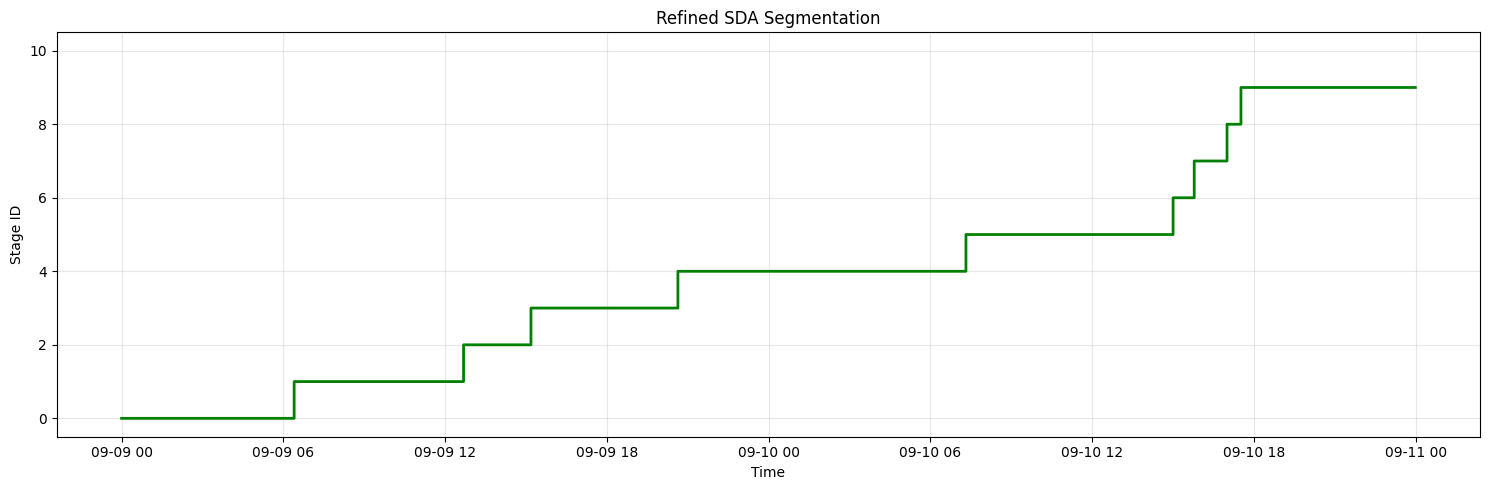

 stage  duration_minutes          start_time            end_time  mean_intensity    max_intensity   std_intensity
     0               384 2011-09-09 00:00:00 2011-09-09 06:23:00   31.2598276232  1577.5007699400   53.0539534185
     1               377 2011-09-09 06:24:00 2011-09-09 12:40:00   85.0388869821  7350.4665558800  160.1090595407
     2               150 2011-09-09 12:41:00 2011-09-09 15:10:00  174.9445524144  6307.5137810100  290.4365667753
     3               327 2011-09-09 15:11:00 2011-09-09 20:37:00   77.4798844418 19139.0930425000  241.8721073011
     4               641 2011-09-09 20:38:00 2011-09-10 07:18:00   32.2143817373  3826.8288634700   72.6944925155
     5               461 2011-09-10 07:19:00 2011-09-10 14:59:00   74.6469829989  7058.2323301700  137.5282351162
     6                47 2011-09-10 15:00:00 2011-09-10 15:46:00  328.2468146070 67291.0758810881 2854.1461616201
     7                73 2011-09-10 15:47:00 2011-09-10 16:59:00   58.3505406292  1608.7

In [ ]:
target_stage = 3
refined_stage_ids, refined_edges = refine_segment(processed_data, stage_ids, edges, target_stage, SDA_PARAMS)

stats_df_refined = analyze_segment_statistics(processed_data, refined_stage_ids)
print(stats_df_refined)

output_data_refined = processed_data.copy()
output_data_refined['stage_id'] = refined_stage_ids
output_data_refined['segment_boundary'] = False
valid_edges_refined = [edge for edge in refined_edges if edge < len(output_data_refined)]
output_data_refined.loc[output_data_refined.index[valid_edges_refined], 'segment_boundary'] = True

output_data_refined.to_csv("sda_refined_results.csv")
stats_df_refined.to_csv("segment_statistics_refined.csv", index=False)

## Визуализация

In [ ]:
def plot_each_metric_by_stage(data, stage_ids):
    df = data.copy()
    df["stage_id"] = stage_ids

    feature_cols = [col for col in df.columns if col not in ["datetime", "stage_id"]]

    grouped = df.groupby("stage_id")[feature_cols].mean()

    for feature in feature_cols:
        plt.figure(figsize=(8, 4))
        grouped[feature].plot(kind="bar", color="skyblue", edgecolor="black")

        plt.title(f"{feature} across SDA segments")
        plt.xlabel("Stage ID")
        plt.ylabel("Mean value")
        plt.grid(axis="y", alpha=0.3)
        plt.tight_layout()
        plt.show()

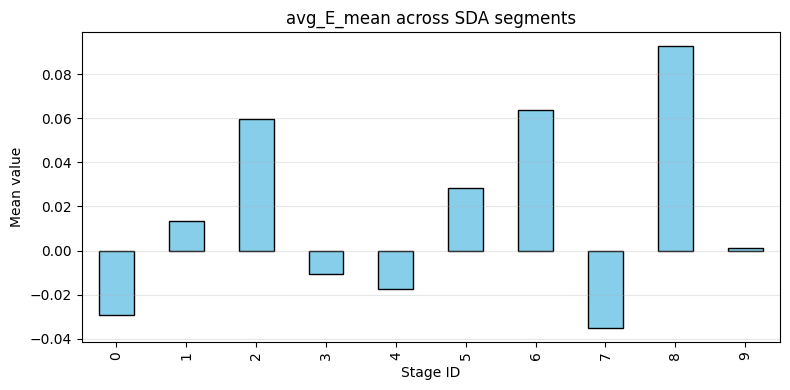

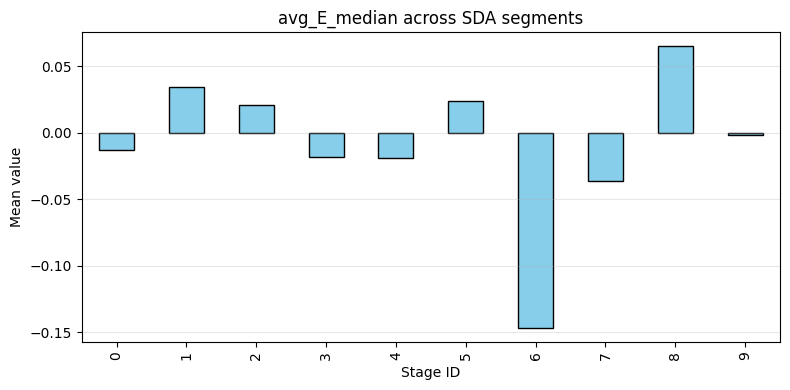

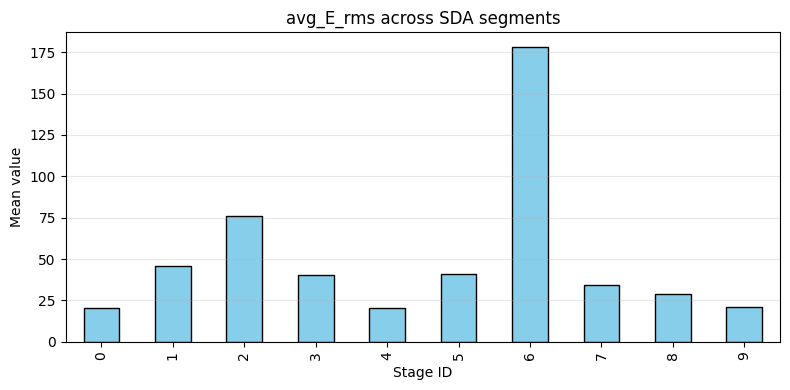

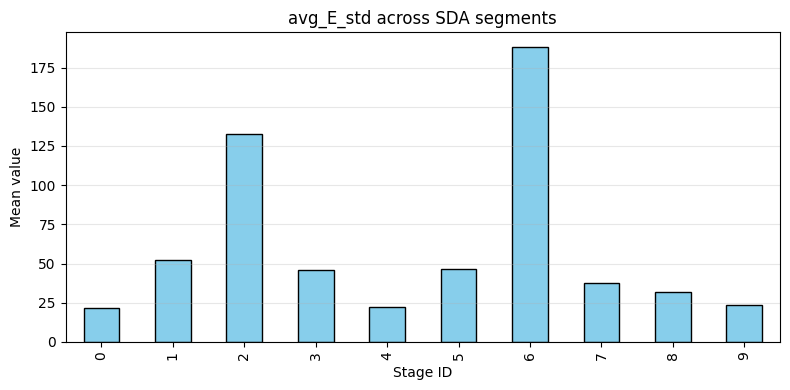

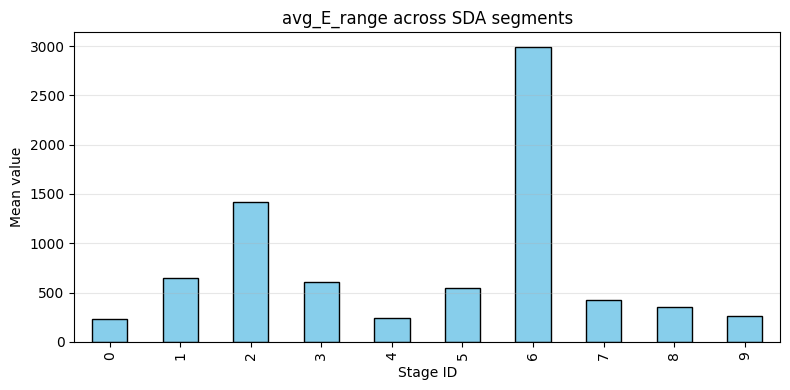

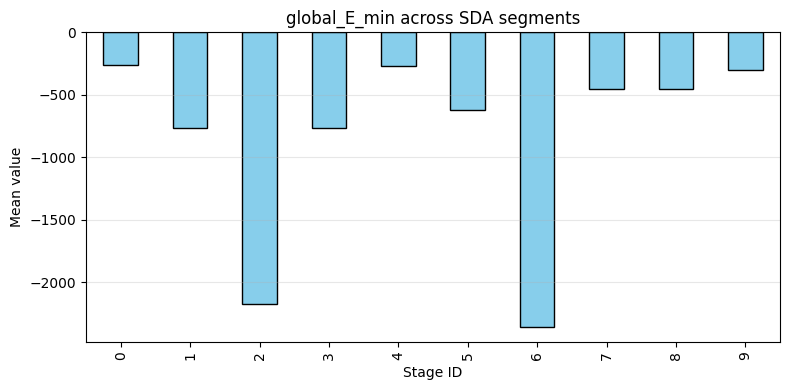

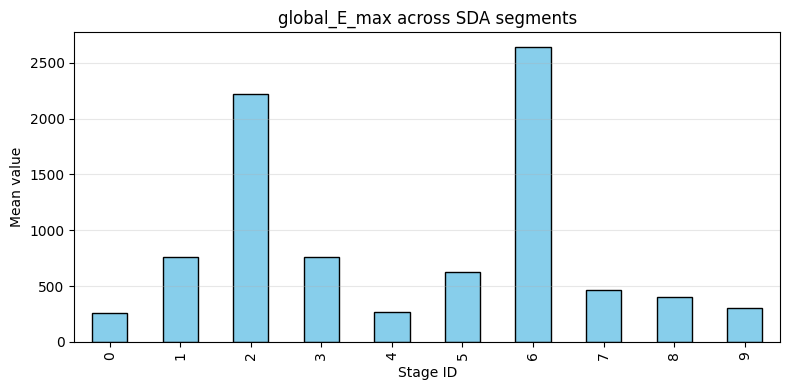

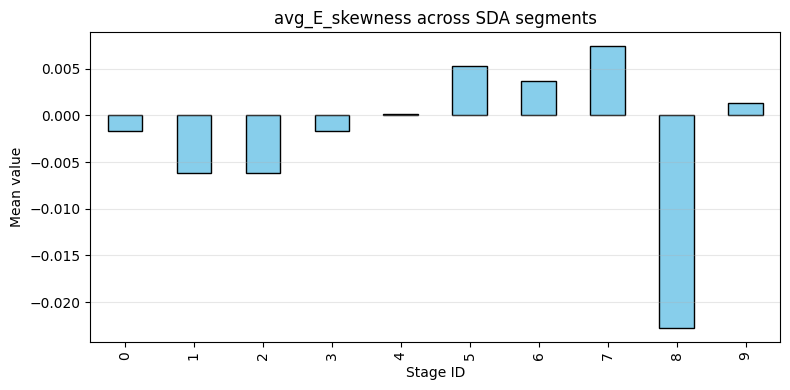

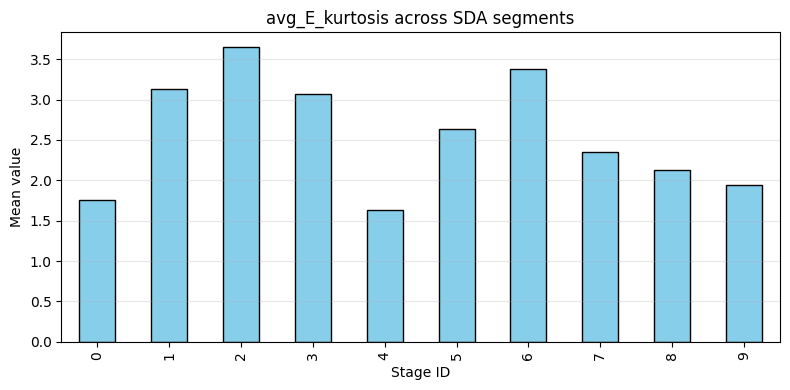

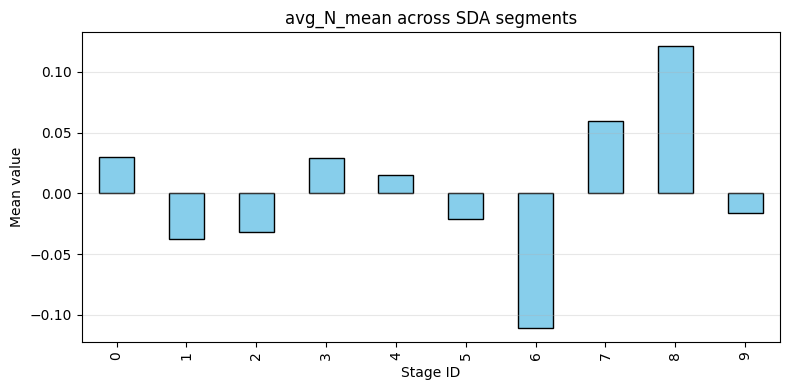

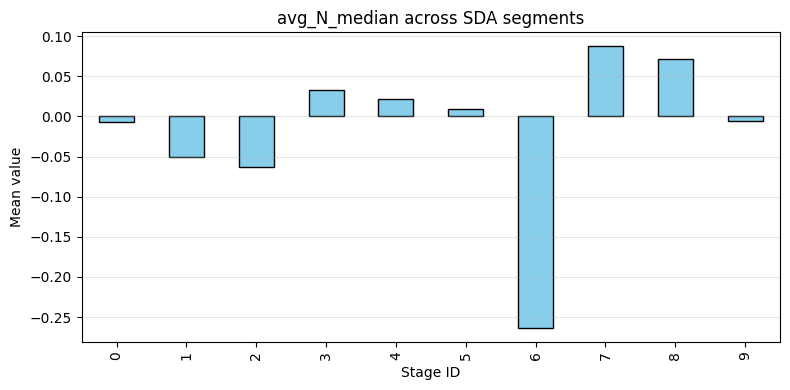

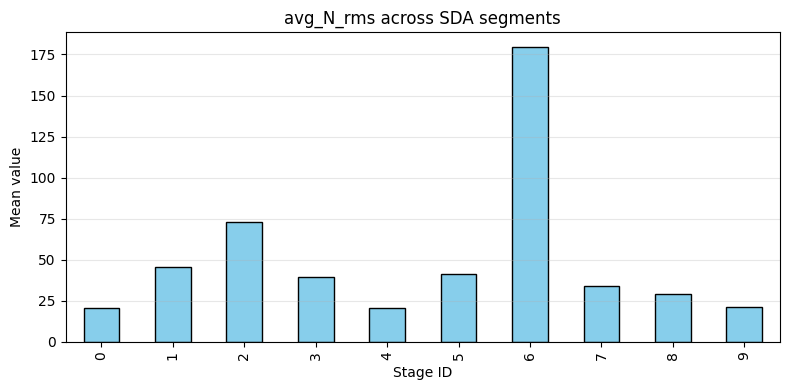

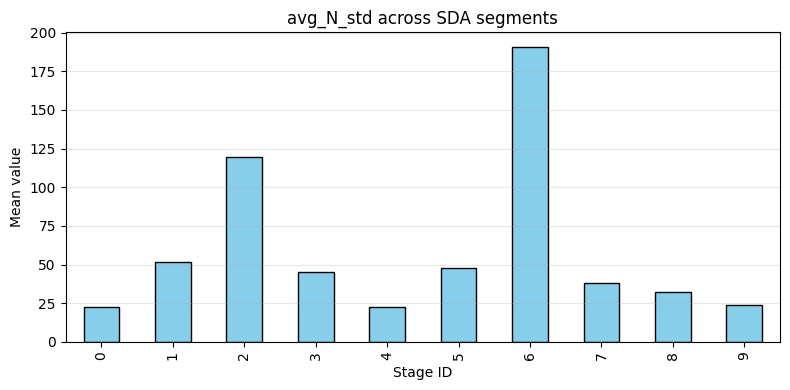

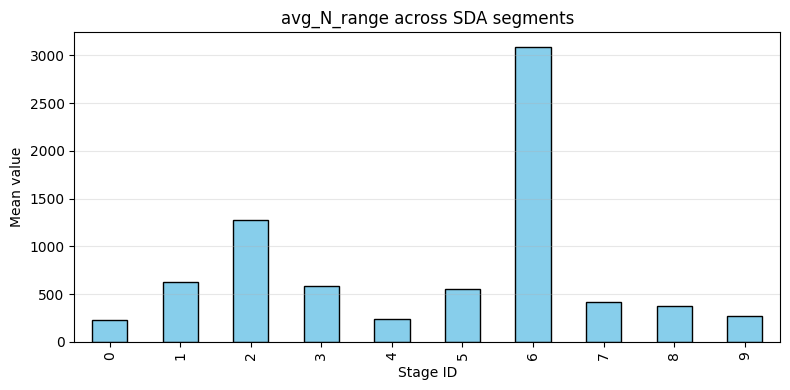

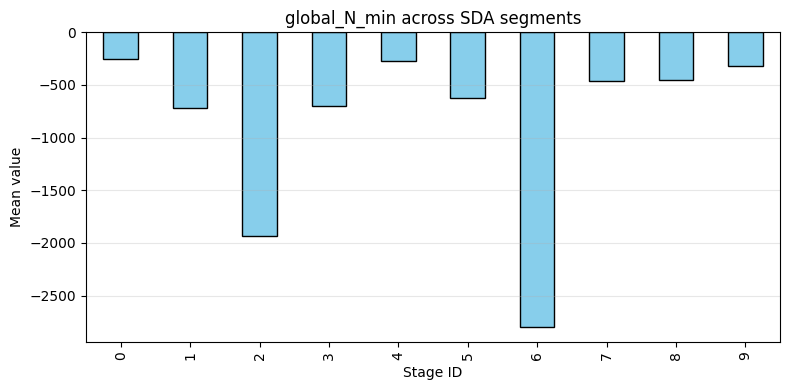

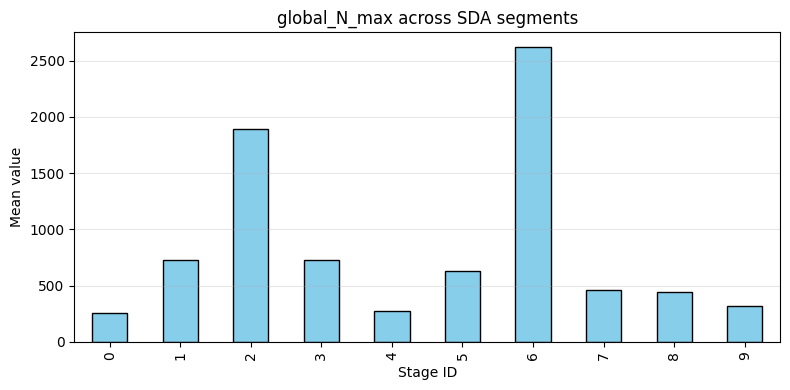

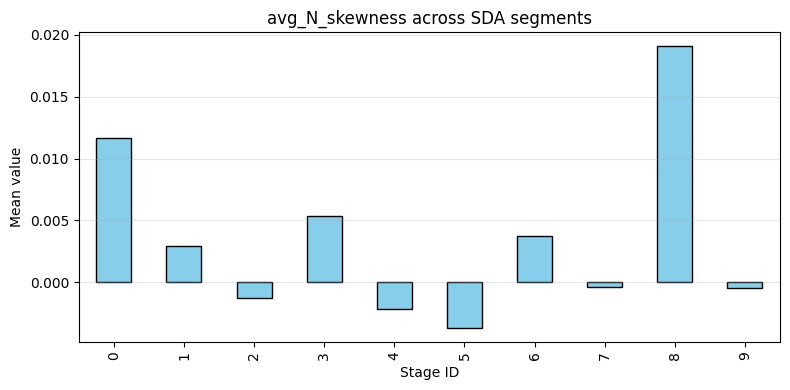

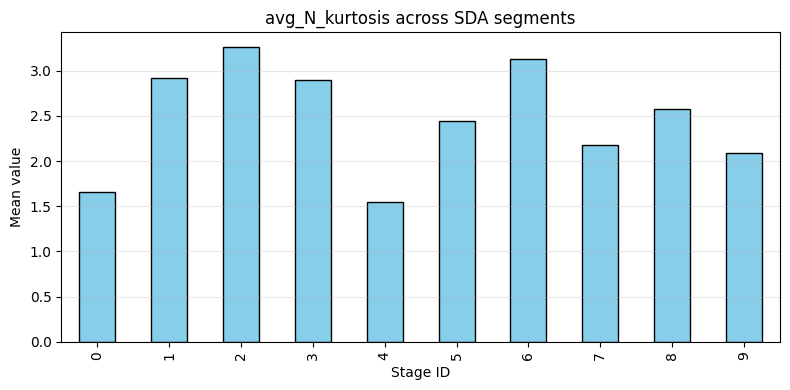

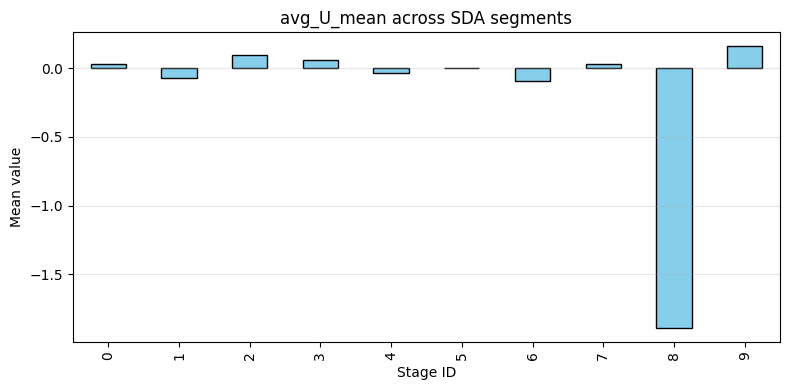

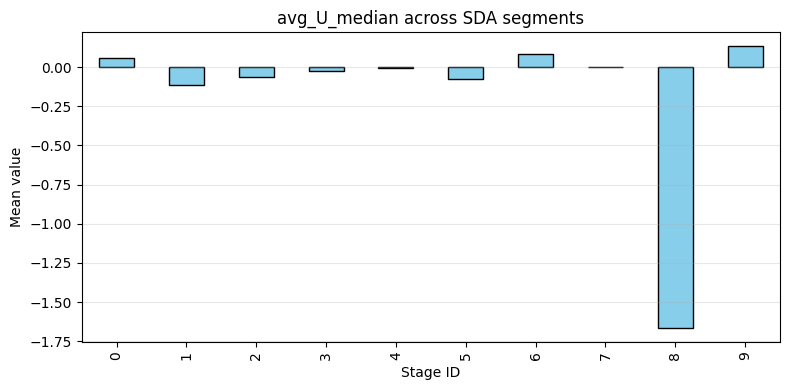

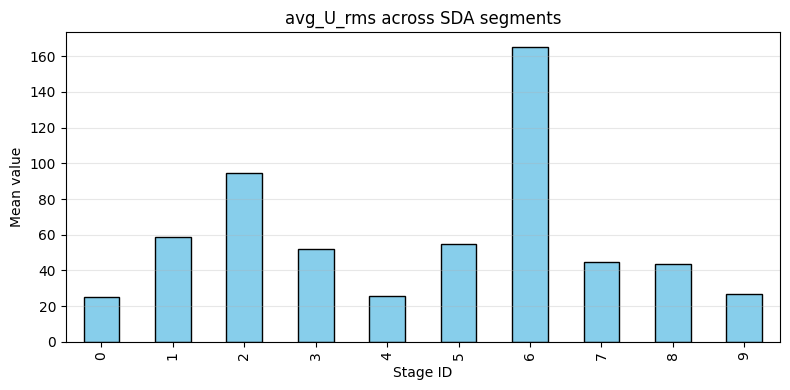

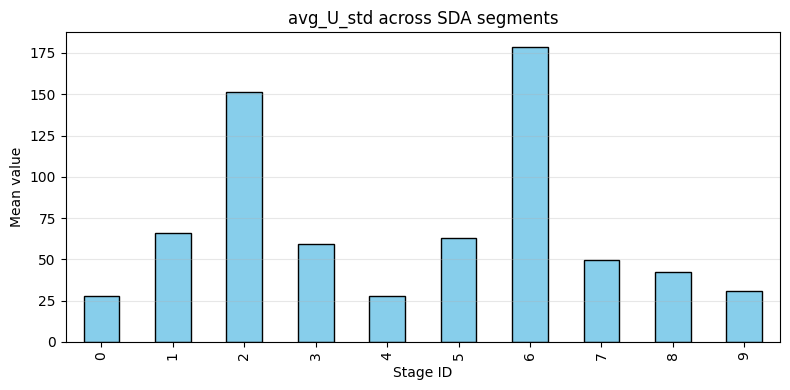

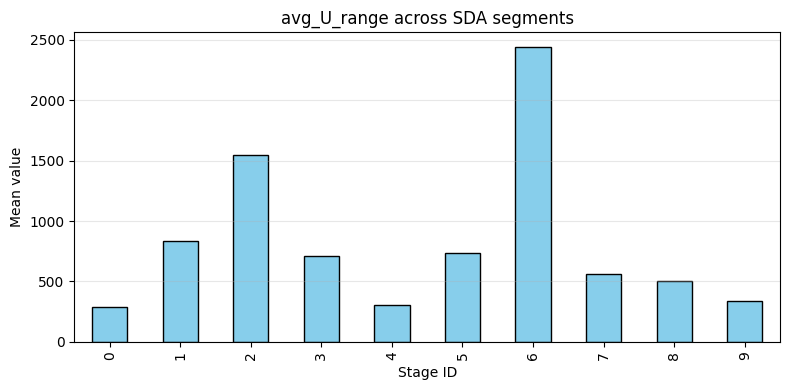

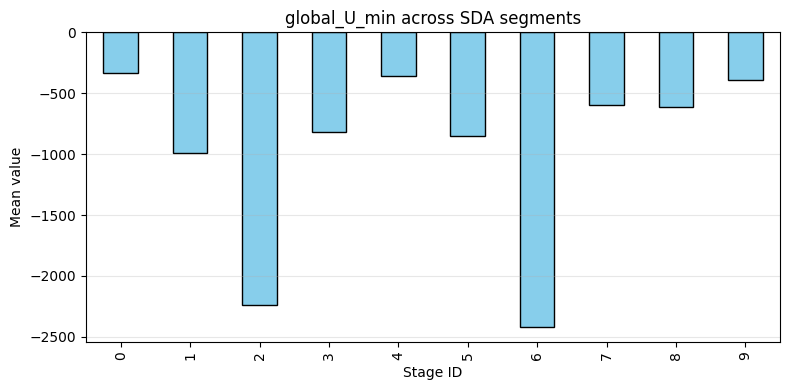

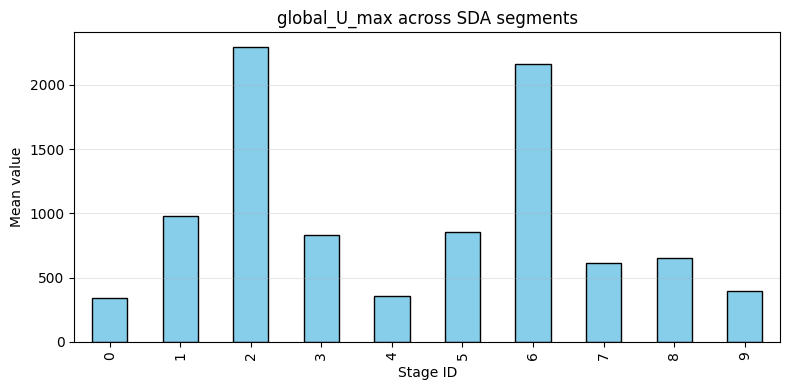

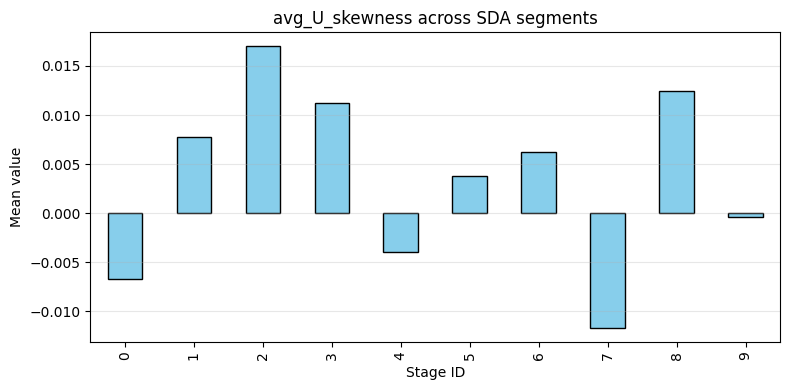

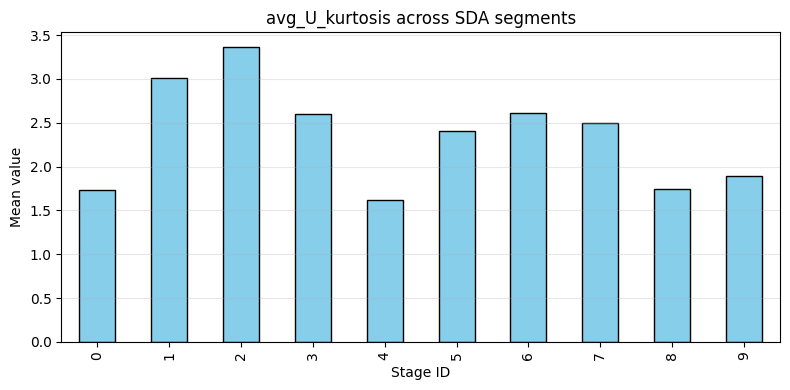

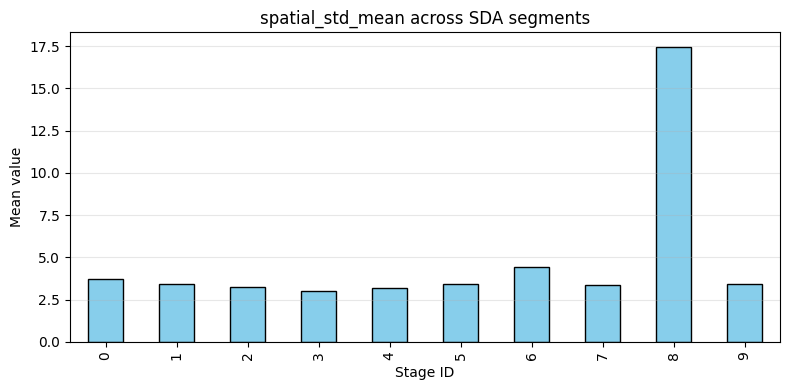

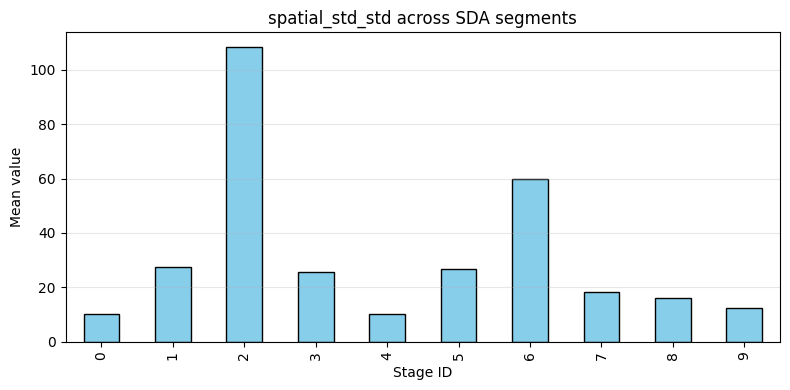

In [ ]:
plot_each_metric_by_stage(processed_data, refined_stage_ids)

## KMeans

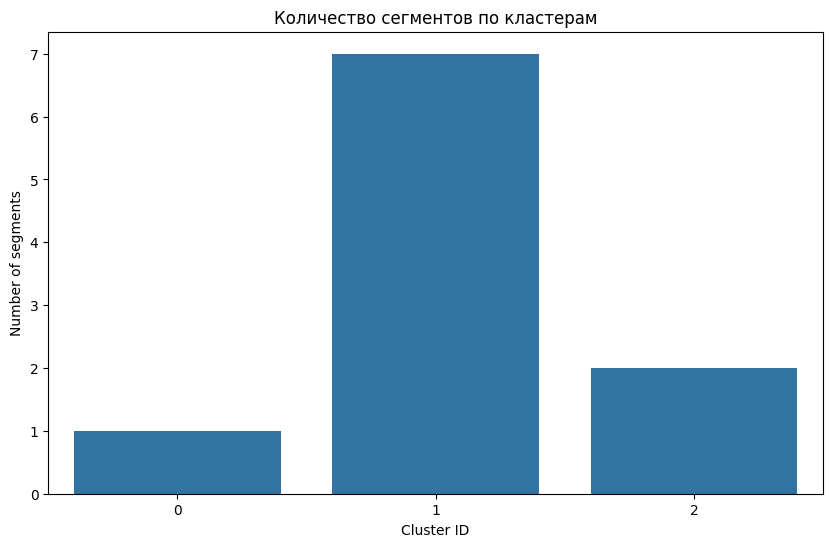

Сегмент 0 → Кластер 1
Сегмент 1 → Кластер 1
Сегмент 2 → Кластер 2
Сегмент 3 → Кластер 1
Сегмент 4 → Кластер 1
Сегмент 5 → Кластер 1
Сегмент 6 → Кластер 2
Сегмент 7 → Кластер 1
Сегмент 8 → Кластер 0
Сегмент 9 → Кластер 1


In [ ]:
segment_features = processed_data.copy()
segment_features['stage_id'] = refined_stage_ids

segment_means = segment_features.groupby('stage_id').mean()

scaler = StandardScaler()
X = scaler.fit_transform(segment_means)

k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=50)
kmeans.fit(X)

segment_means['cluster'] = kmeans.labels_

plt.figure(figsize=(10,6))
sns.countplot(x='cluster', data=segment_means)
plt.title("Количество сегментов по кластерам")
plt.xlabel("Cluster ID")
plt.ylabel("Number of segments")
plt.show()

for sid, cluster in segment_means['cluster'].items():
    print(f"Сегмент {sid} → Кластер {cluster}")

## А теперь то же самое, но по часам


In [ ]:
def split_data_by_hours(data: pd.DataFrame, time_col: str = "datetime"):
    if time_col not in data.columns:
        raise ValueError(f"Столбец '{time_col}' не найден в данных")

    df = data.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df["hour"] = df[time_col].dt.floor("H")

    grouped = df.groupby("hour")
    hour_groups = {}

    print(f"Найдено {len(grouped)} часовых интервалов")

    for hour, group in tqdm(grouped, desc="Разделение по часам"):
        hour_groups[hour] = group.drop(columns=["hour"])

    print(f"Сохранено {len(hour_groups)} непустых часовых групп")
    return hour_groups

In [ ]:
hourly_groups = split_data_by_hours(averaged_metrics_df)

/tmp/ipython-input-717021589.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour"] = df[time_col].dt.floor("H")


▶ Найдено 48 часовых интервалов


Разделение по часам: 100%|██████████| 48/48 [00:00<00:00, 1171.55it/s]

✅ Сохранено 48 непустых часовых групп


In [ ]:
def run_hourly_sda(hourly_groups, sda_params, min_points=10, save_every=10):

    sda = SDA(**sda_params)
    all_segments = []
    processed_hours = 0

    temp_files = sorted([f for f in os.listdir() if f.startswith("hourly_sda_temp_") and f.endswith(".csv")])

    if temp_files:
        print("Найдены промежуточные результаты:")
        for f in temp_files:
            print("   •", f)

        all_segments = pd.concat([pd.read_csv(f, parse_dates=["hour", "start_time", "end_time"]) for f in temp_files], ignore_index=True)
        processed_hours = len(all_segments["hour"].unique())
        print(f"✅ Восстановлено {len(all_segments)} сегментов из {processed_hours} часов")


        processed_set = set(pd.to_datetime(all_segments["hour"]).unique())

        all_segments = all_segments.to_dict("records")
        processed_set = set(pd.to_datetime([d["hour"] for d in all_segments]))
    else:
        processed_set = set()

    total_hours = len(hourly_groups)
    print(f"Запуск SDA по {total_hours} часовым интервалам (последовательно)\n")

    for hour_i, (hour, df_hour) in enumerate(sorted(hourly_groups.items()), start=1):

        if hour in processed_set:
            print(f"Пропуск часа {hour} — уже обработан ранее")
            continue

        print(f"Обработка часа {hour_i}/{total_hours}: {hour}")

        print(len(df_hour))

        X = df_hour.drop(columns=["datetime"]).values
        if X.shape[0] < 5:
            print("Пропущен")
            continue

        X_scaled = StandardScaler().fit_transform(X)
        res, edges_df = sda.apply(X_scaled)

        # Выбор лучшей сегментации
        #print(res.info())
        #print(edges_df.info())
        best_i = res["Avg-Silh"].idxmax()
        best_row = res.loc[best_i]
        raw_edges = best_row["St_edges"]

        if isinstance(raw_edges, str):
            edges = [int(x) for x in raw_edges.strip("[]").split() if x.strip().isdigit()]
        else:
            edges = list(raw_edges)

        if len(edges) < 2:
            print("Недостаточно границ сегментов")
            continue

        times = df_hour["datetime"].values
        for seg_id, (st, en) in enumerate(zip(edges[:-1], edges[1:])):
            seg_data = df_hour.iloc[st:en]
            if seg_data.empty:
                continue

            seg_features = seg_data.drop(columns=["datetime"], errors="ignore").mean().to_dict()
            all_segments.append({
                "hour": hour,
                "segment_id": seg_id,
                "start_time": seg_data["datetime"].iloc[0],
                "end_time": seg_data["datetime"].iloc[-1],
                **seg_features
            })

        processed_hours += 1

        if processed_hours % save_every == 0:
            temp_path = f"hourly_sda_temp_{processed_hours}.csv"
            pd.DataFrame(all_segments).to_csv(temp_path, index=False)
            print(f"Промежуточные результаты сохранены ({len(all_segments)} сегментов) → {temp_path}")

        # Очистка памяти
        del X_scaled, X, res, edges_df
        gc.collect()

    if not all_segments:
        print("Не найдено ни одного сегмента.")
        return pd.DataFrame()

    segments_df = pd.DataFrame(all_segments).sort_values("start_time").reset_index(drop=True)
    segments_df.to_csv("hourly_sda_segments_full.csv", index=False)

    print(f"\n✅ SDA завершён: найдено {len(segments_df)} сегментов из {processed_hours} часов")
    print("Результаты сохранены в 'hourly_sda_segments_full.csv'")

    return segments_df

In [ ]:
segments_df = run_hourly_sda(hourly_groups, SDA_PARAMS)

print("\nПример найденных сегментов:")
print(segments_df.head())

Промежуточные файлы не найдены — запуск с нуля

Запуск SDA по 48 часовым интервалам (последовательно)

Обработка часа 1/48: 2011-09-09 00:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:45<00:00, 14.70it/s]


Обработка часа 2/48: 2011-09-09 01:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:48<00:00, 13.73it/s]


Обработка часа 3/48: 2011-09-09 02:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:41<00:00, 16.12it/s]


Обработка часа 4/48: 2011-09-09 03:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:38<00:00, 17.60it/s]


Обработка часа 5/48: 2011-09-09 04:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:51<00:00, 13.17it/s]


Обработка часа 6/48: 2011-09-09 05:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:48<00:00, 13.98it/s]


Обработка часа 7/48: 2011-09-09 06:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:44<00:00, 15.19it/s]


Обработка часа 8/48: 2011-09-09 07:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:40<00:00, 16.40it/s]


Обработка часа 9/48: 2011-09-09 08:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:47<00:00, 14.04it/s]


Обработка часа 10/48: 2011-09-09 09:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:44<00:00, 15.21it/s]


Промежуточные результаты сохранены (42 сегментов) → hourly_sda_temp_10.csv
Обработка часа 11/48: 2011-09-09 10:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:43<00:00, 15.53it/s]


Обработка часа 12/48: 2011-09-09 11:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:47<00:00, 14.11it/s]


Обработка часа 13/48: 2011-09-09 12:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:38<00:00, 17.54it/s]


Обработка часа 14/48: 2011-09-09 13:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:43<00:00, 15.47it/s]


Обработка часа 15/48: 2011-09-09 14:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:46<00:00, 14.45it/s]


Обработка часа 16/48: 2011-09-09 15:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:32<00:00, 20.59it/s]


Обработка часа 17/48: 2011-09-09 16:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:48<00:00, 13.72it/s]


Обработка часа 18/48: 2011-09-09 17:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:52<00:00, 12.87it/s]


Обработка часа 19/48: 2011-09-09 18:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:46<00:00, 14.59it/s]


Обработка часа 20/48: 2011-09-09 19:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:43<00:00, 15.48it/s]


Промежуточные результаты сохранены (82 сегментов) → hourly_sda_temp_20.csv
Обработка часа 21/48: 2011-09-09 20:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:57<00:00, 11.61it/s]


Обработка часа 22/48: 2011-09-09 21:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:39<00:00, 17.03it/s]


Обработка часа 23/48: 2011-09-09 22:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:57<00:00, 11.66it/s]


Обработка часа 24/48: 2011-09-09 23:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:39<00:00, 17.11it/s]


Обработка часа 25/48: 2011-09-10 00:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:41<00:00, 16.33it/s]


Обработка часа 26/48: 2011-09-10 01:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:45<00:00, 14.72it/s]


Обработка часа 27/48: 2011-09-10 02:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:54<00:00, 12.42it/s]


Обработка часа 28/48: 2011-09-10 03:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:44<00:00, 14.99it/s]


Обработка часа 29/48: 2011-09-10 04:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:48<00:00, 13.72it/s]


Обработка часа 30/48: 2011-09-10 05:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:46<00:00, 14.54it/s]


Промежуточные результаты сохранены (130 сегментов) → hourly_sda_temp_30.csv
Обработка часа 31/48: 2011-09-10 06:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:41<00:00, 16.19it/s]


Обработка часа 32/48: 2011-09-10 07:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:34<00:00, 19.21it/s]


Обработка часа 33/48: 2011-09-10 08:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:49<00:00, 13.52it/s]


Обработка часа 34/48: 2011-09-10 09:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:47<00:00, 14.04it/s]


Обработка часа 35/48: 2011-09-10 10:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:40<00:00, 16.53it/s]


Обработка часа 36/48: 2011-09-10 11:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:40<00:00, 16.47it/s]


Обработка часа 37/48: 2011-09-10 12:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:48<00:00, 13.85it/s]


Обработка часа 38/48: 2011-09-10 13:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:50<00:00, 13.27it/s]


Обработка часа 39/48: 2011-09-10 14:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:49<00:00, 13.63it/s]


Обработка часа 40/48: 2011-09-10 15:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:32<00:00, 20.92it/s]


Промежуточные результаты сохранены (162 сегментов) → hourly_sda_temp_40.csv
Обработка часа 41/48: 2011-09-10 16:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:37<00:00, 17.74it/s]


Обработка часа 42/48: 2011-09-10 17:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:42<00:00, 15.66it/s]


Обработка часа 43/48: 2011-09-10 18:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:47<00:00, 14.16it/s]


Обработка часа 44/48: 2011-09-10 19:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:38<00:00, 17.47it/s]


Обработка часа 45/48: 2011-09-10 20:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:38<00:00, 17.33it/s]


Обработка часа 46/48: 2011-09-10 21:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:49<00:00, 13.52it/s]


Обработка часа 47/48: 2011-09-10 22:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:54<00:00, 12.28it/s]


Обработка часа 48/48: 2011-09-10 23:00:00
360
Applying to 360 samples with 26 features each


stage 2: 100%|██████████| 672/672 [00:50<00:00, 13.31it/s]



✅ SDA завершён: найдено 187 сегментов из 48 часов
Результаты сохранены в 'hourly_sda_segments_full.csv'

Пример найденных сегментов:
                 hour  segment_id          start_time            end_time  \
0 2011-09-09 00:00:00           0 2011-09-09 00:00:00 2011-09-09 00:22:20   
1 2011-09-09 00:00:00           1 2011-09-09 00:22:30 2011-09-09 00:47:00   
2 2011-09-09 00:00:00           2 2011-09-09 00:47:10 2011-09-09 00:50:50   
3 2011-09-09 00:00:00           3 2011-09-09 00:51:00 2011-09-09 00:59:50   
4 2011-09-09 01:00:00           0 2011-09-09 01:00:00 2011-09-09 01:06:50   

   avg_E_median     avg_E_rms     avg_E_std    avg_E_range    global_E_min  \
0 11.6974972391 17.4379247360 18.4854790803 124.1051320332 -138.9053722623   
1 11.4102189732 16.4910844816 17.0410913380 105.4635981507 -105.7417074263   
2 11.6783121361 17.9664788965 19.6964499569 159.8852038703 -207.0873179621   
3 10.8283835866 15.8501795095 16.5871867834 105.7531651611 -114.1556672505   
4 11.75883718

In [ ]:
feature_cols = [c for c in segments_df.columns if segments_df[c].dtype in [float, int]]
z_scores = np.abs(stats.zscore(segments_df[feature_cols]))
filtered_df = segments_df[(z_scores < 3).all(axis=1)]
print(f"Исходный размер: {segments_df.shape}, после удаления выбросов: {filtered_df.shape}")

Исходный размер: (186, 31), после удаления выбросов: (172, 31)


## KMeans

In [ ]:
def cluster_segments_kmeans(segments_df, k_range=(3, 10), random_state=42):

    feature_cols = [
        c for c in segments_df.columns
        if c not in ["hour", "segment_id", "start_time", "end_time"]
        and np.issubdtype(segments_df[c].dtype, np.number)
    ]

    X = segments_df[feature_cols].values
    X_scaled = StandardScaler().fit_transform(X)

    metrics = []

    for k in range(k_range[0], k_range[1] + 1):
        km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = km.fit_predict(X_scaled)

        sil = silhouette_score(X_scaled, labels)
        ch = calinski_harabasz_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)

        metrics.append({"k": k, "silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db})
        print(f"k={k:2d} | silhouette={sil:.3f} | CH={ch:.1f} | DB={db:.3f}")

    metrics_df = pd.DataFrame(metrics)

    fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    ax[0].plot(metrics_df["k"], metrics_df["silhouette"], marker="o")
    ax[0].set_title("Silhouette score")
    ax[0].set_xlabel("k"); ax[0].set_ylabel("Score")

    ax[1].plot(metrics_df["k"], metrics_df["calinski_harabasz"], marker="o")
    ax[1].set_title("Calinski-Harabasz")
    ax[1].set_xlabel("k")

    ax[2].plot(metrics_df["k"], metrics_df["davies_bouldin"], marker="o")
    ax[2].invert_yaxis()  # чем меньше — тем лучше
    ax[2].set_title("Davies-Bouldin")
    ax[2].set_xlabel("k")

    plt.tight_layout()
    plt.show()

    # Выбор оптимального числа кластеров
    best_k = 5
    print(f"\nk = {best_k}")

    final_kmeans = KMeans(n_clusters=best_k, random_state=random_state, n_init=20)
    segments_df["cluster"] = final_kmeans.fit_predict(X_scaled)

    print(f"Кластеризация завершена: {best_k} кластеров, {len(segments_df)} сегментов")

    cluster_counts = segments_df["cluster"].value_counts().sort_index()
    cluster_share = (cluster_counts / len(segments_df) * 100).round(2)

    print("\nРаспределение сегментов по кластерам:")
    for cid in cluster_counts.index:
        print(f"  Кластер {cid}: {cluster_counts[cid]} сегментов ({cluster_share[cid]}%)")
    plt.figure(figsize=(6,4))
    cluster_counts.plot(kind="bar", color="skyblue")
    plt.title("Количество сегментов в каждом кластере")
    plt.xlabel("Кластер")
    plt.ylabel("Количество сегментов")
    plt.tight_layout()
    plt.show()

    segments_df.to_csv("segments_clustered.csv", index=False)
    metrics_df.to_csv("clustering_metrics.csv", index=False)
    print("Результаты сохранены в 'segments_clustered.csv' и 'clustering_metrics.csv'")

    return segments_df, metrics_df

k= 3 | silhouette=0.483 | CH=234.3 | DB=0.869
k= 4 | silhouette=0.370 | CH=193.7 | DB=1.074
k= 5 | silhouette=0.380 | CH=180.7 | DB=1.083
k= 6 | silhouette=0.292 | CH=163.0 | DB=1.237
k= 7 | silhouette=0.285 | CH=143.8 | DB=1.330
k= 8 | silhouette=0.220 | CH=128.5 | DB=1.461
k= 9 | silhouette=0.232 | CH=119.1 | DB=1.338
k=10 | silhouette=0.175 | CH=110.4 | DB=1.484


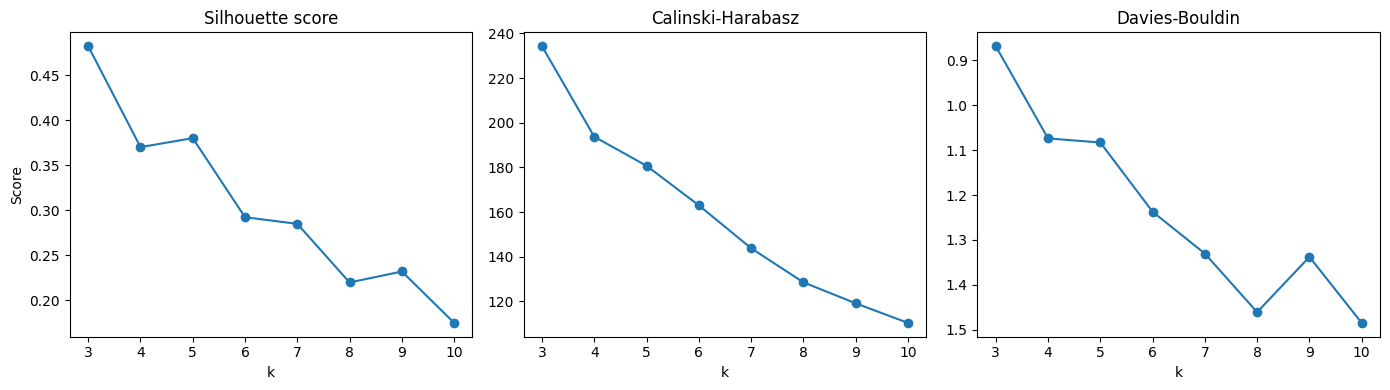


k = 5
Кластеризация завершена: 5 кластеров, 172 сегментов

📈 Распределение сегментов по кластерам:
  Кластер 0: 76 сегментов (44.19%)
  Кластер 1: 36 сегментов (20.93%)
  Кластер 2: 5 сегментов (2.91%)
  Кластер 3: 18 сегментов (10.47%)
  Кластер 4: 37 сегментов (21.51%)


/tmp/ipython-input-2517275040.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segments_df["cluster"] = final_kmeans.fit_predict(X_scaled)


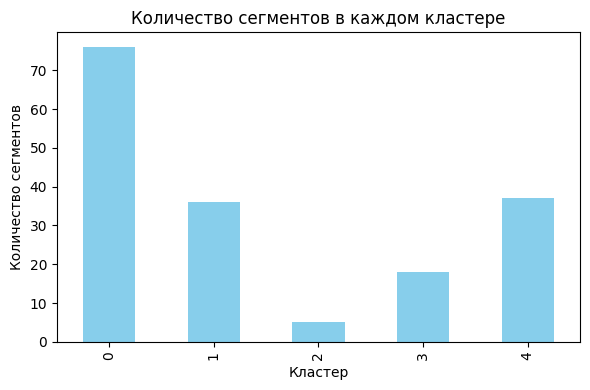

Результаты сохранены в 'segments_clustered.csv' и 'clustering_metrics.csv'


In [ ]:
clustered_segments, clustering_metrics = cluster_segments_kmeans(filtered_df, k_range=(3, 10))

In [ ]:
def plot_each_cluster(data):
    df = data.copy()

    feature_cols = [col for col in df.columns if col not in ["cluster", "hour", "segment_id", "start_time", "end_time"]]

    grouped = df.groupby("cluster")[feature_cols].mean()

    for feature in feature_cols:
        plt.figure(figsize=(8, 4))
        grouped[feature].plot(kind="bar", color="skyblue", edgecolor="black")

        plt.title(f"{feature} across SDA segments")
        plt.xlabel("Stage ID")
        plt.ylabel("Mean value")
        plt.grid(axis="y", alpha=0.3)
        plt.tight_layout()
        plt.show()

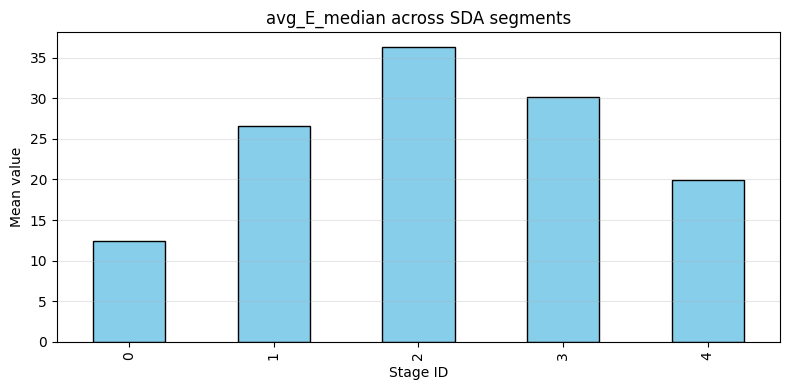

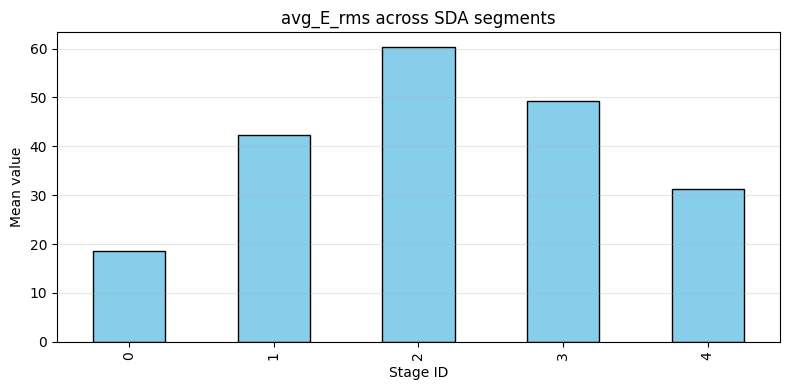

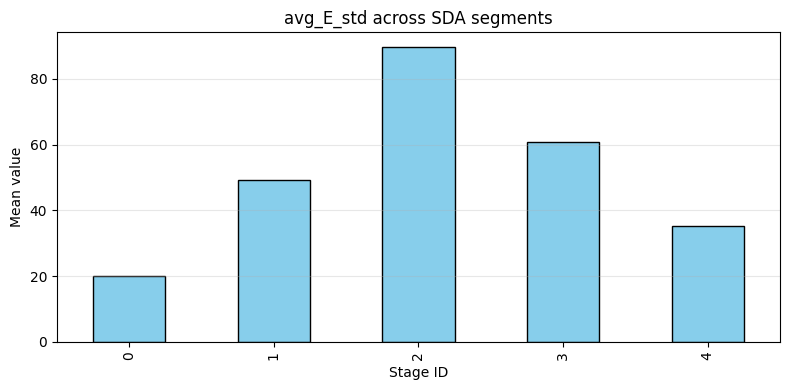

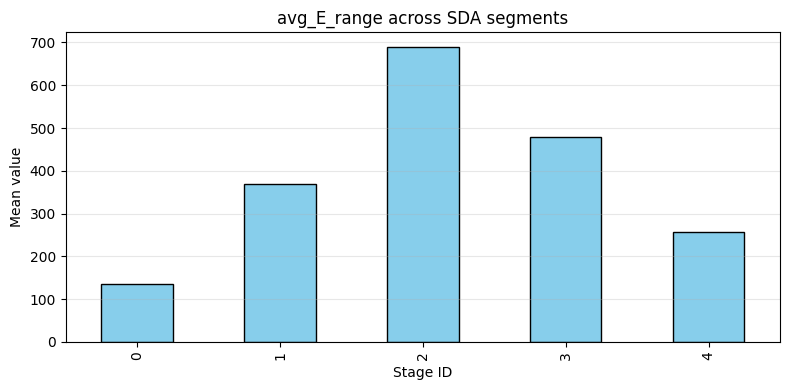

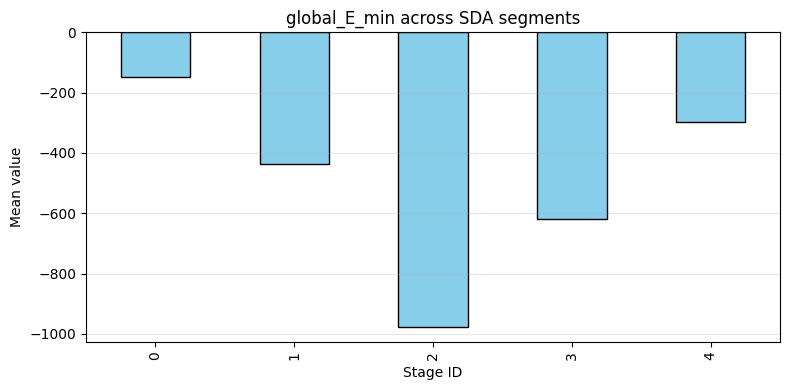

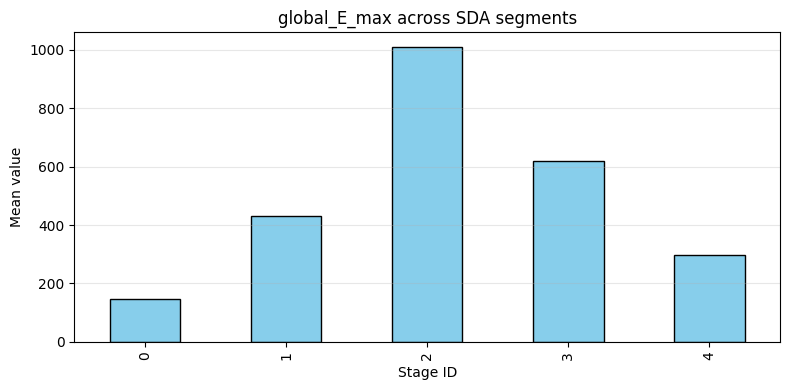

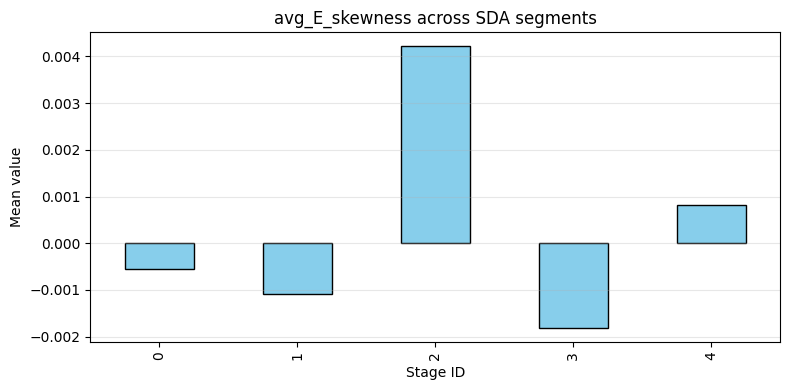

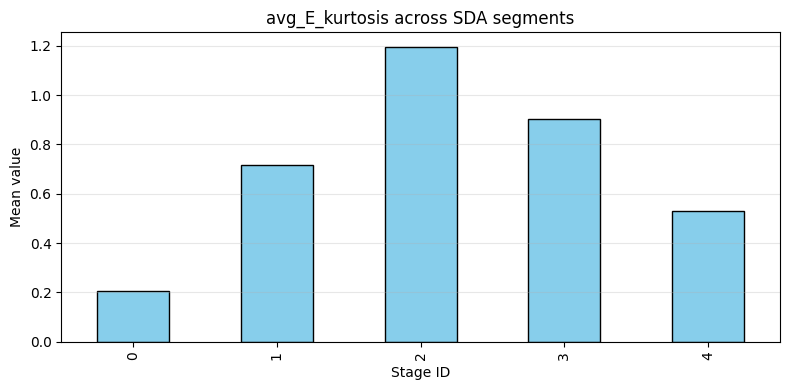

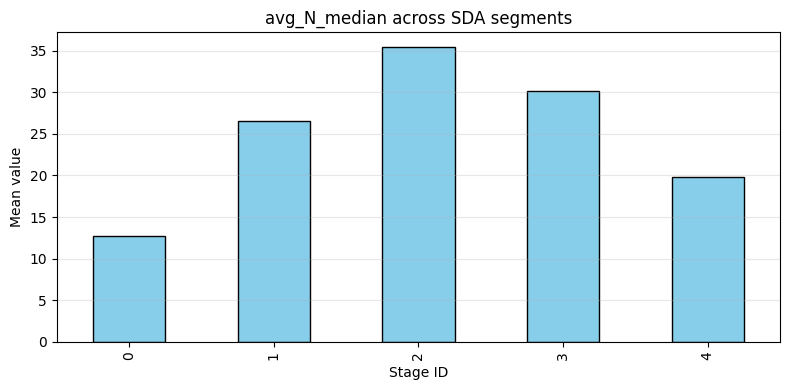

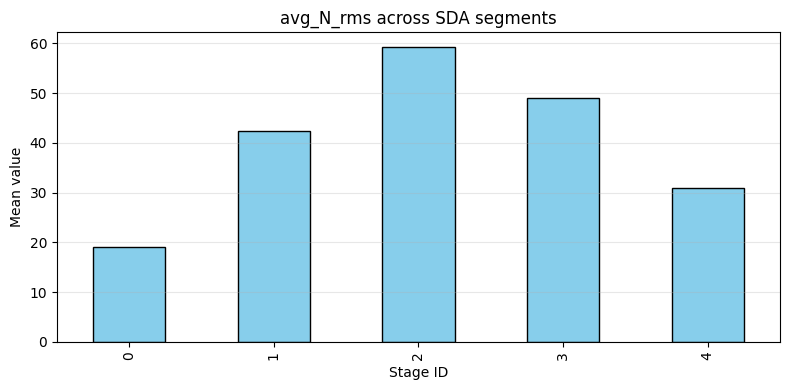

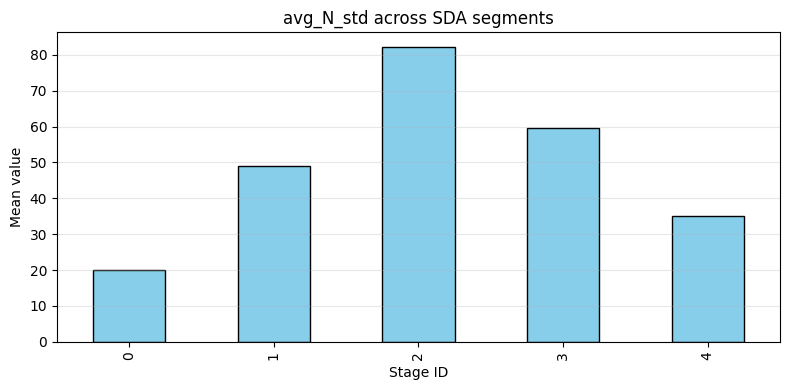

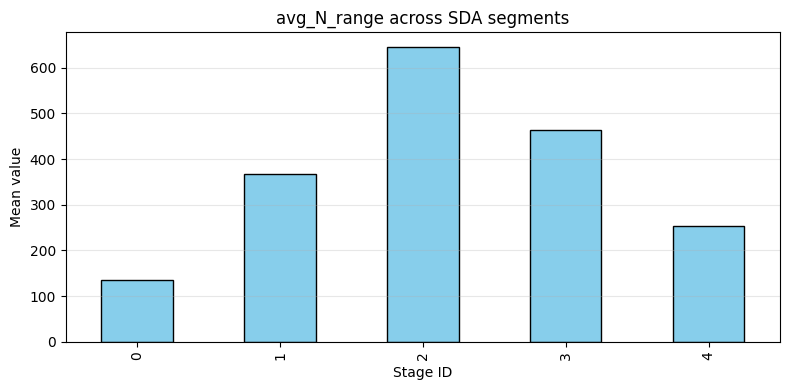

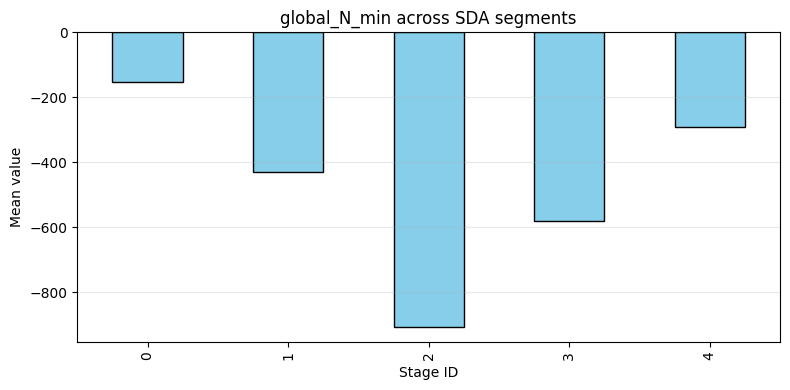

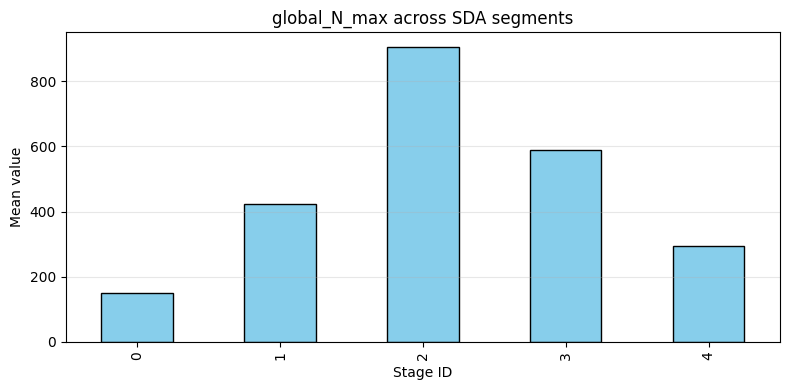

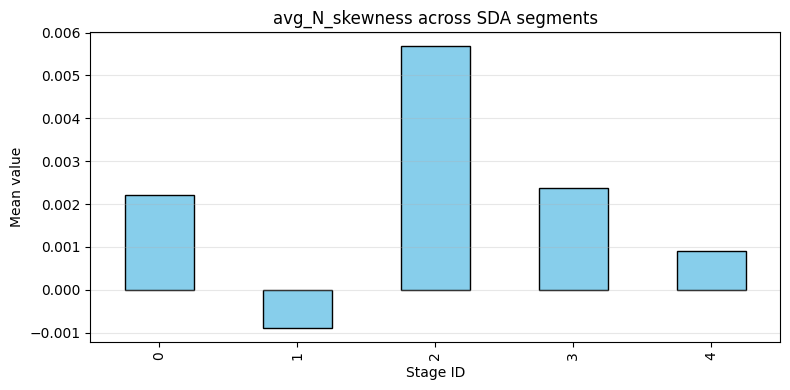

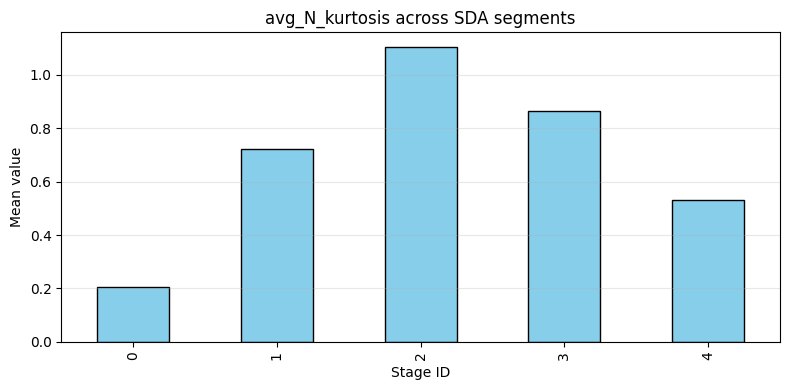

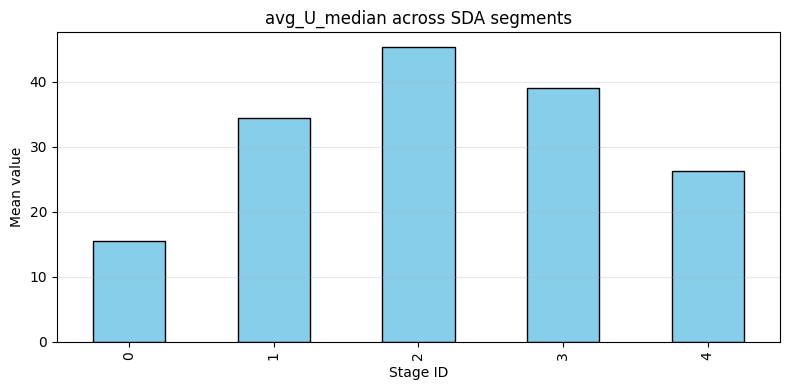

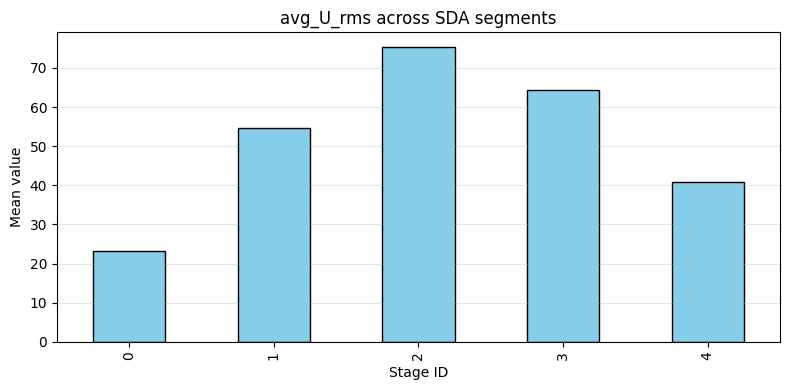

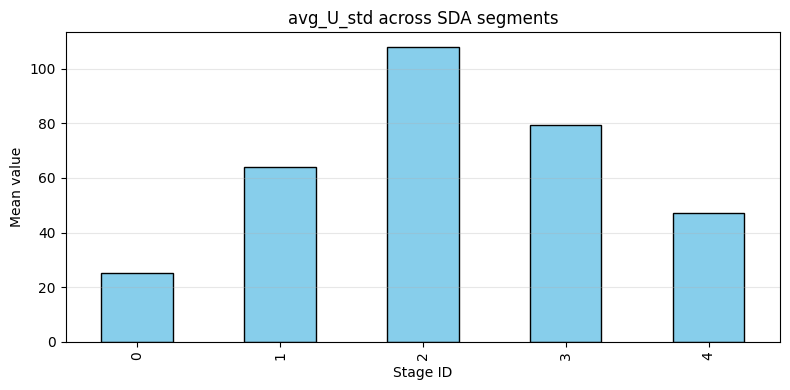

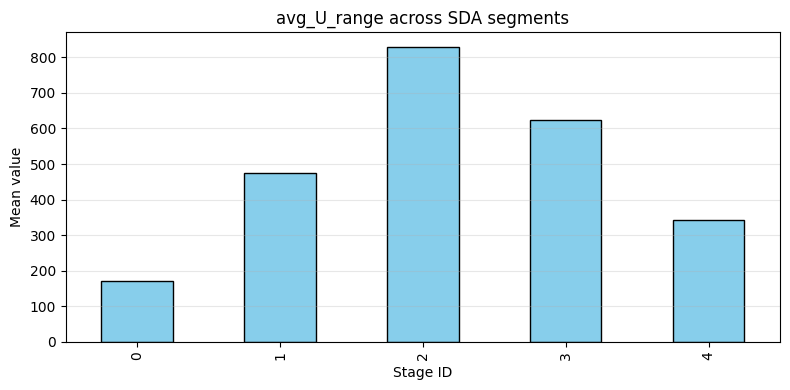

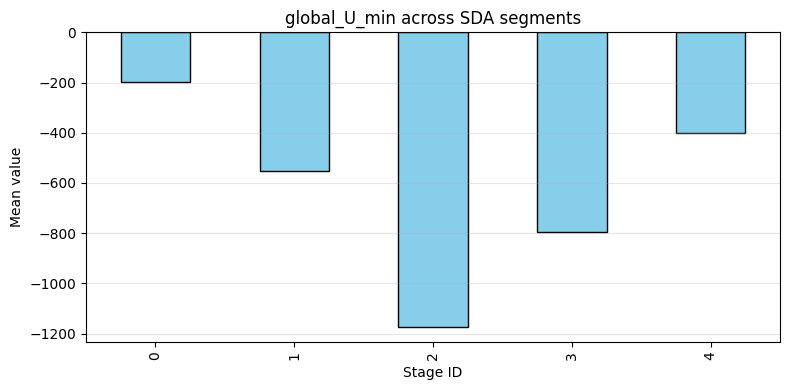

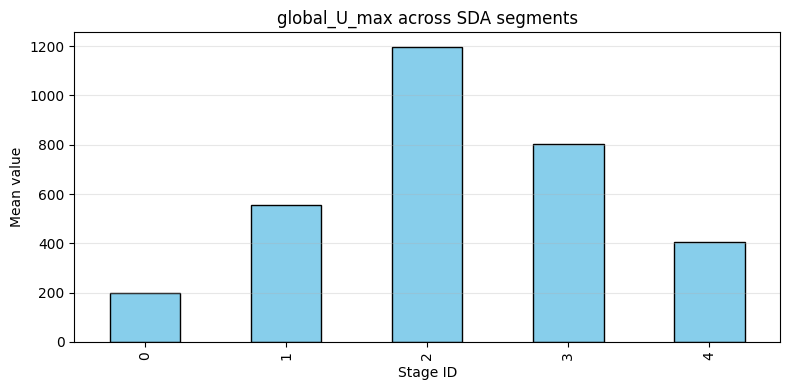

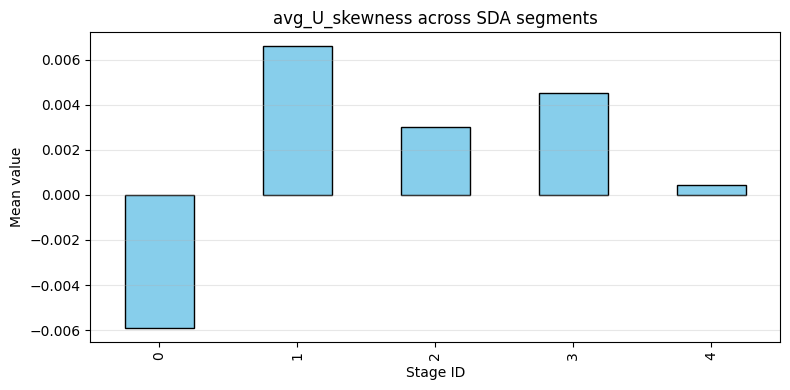

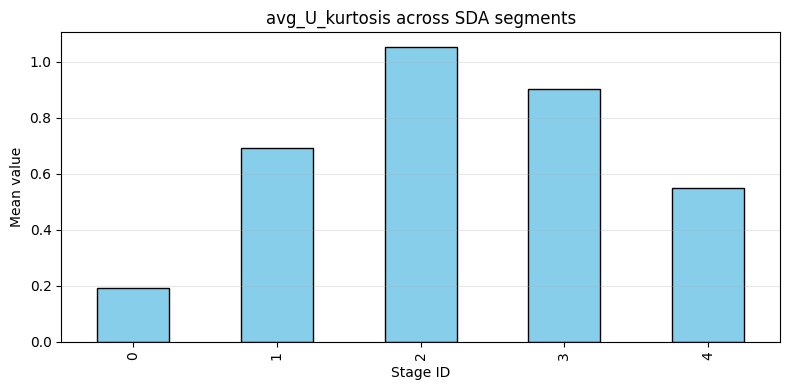

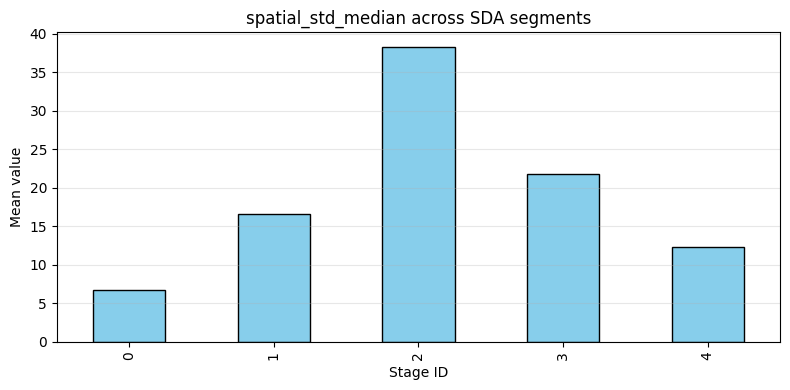

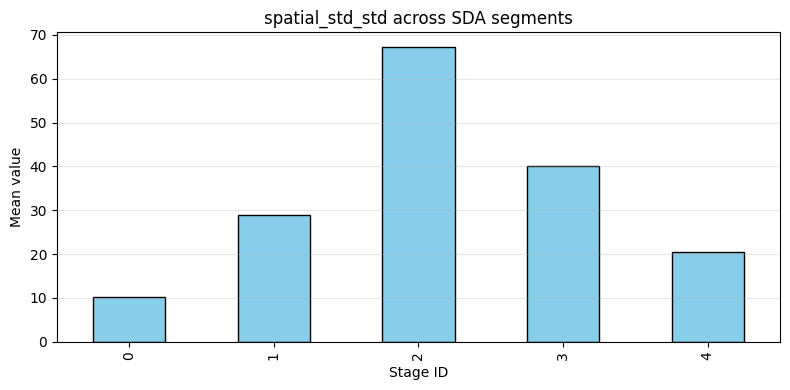

In [ ]:
plot_each_cluster(filtered_df)

## Цепь Маркова

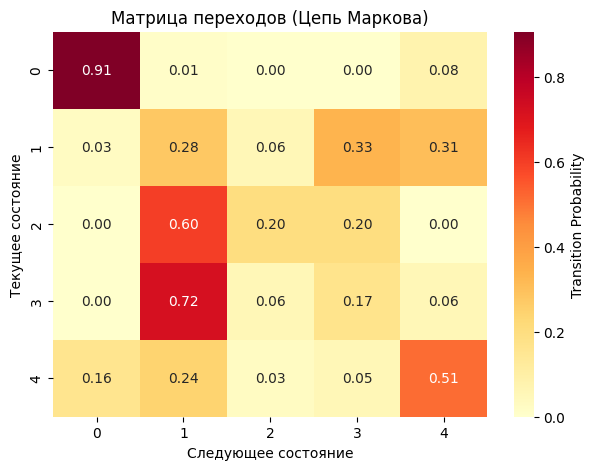


Матрица переходов (в виде таблицы):
               to_0         to_1         to_2         to_3         to_4
from_0 0.9070000000 0.0130000000 0.0000000000 0.0000000000 0.0800000000
from_1 0.0280000000 0.2780000000 0.0560000000 0.3330000000 0.3060000000
from_2 0.0000000000 0.6000000000 0.2000000000 0.2000000000 0.0000000000
from_3 0.0000000000 0.7220000000 0.0560000000 0.1670000000 0.0560000000
from_4 0.1620000000 0.2430000000 0.0270000000 0.0540000000 0.5140000000

Вероятности переходов через 2 шага:
               to_0         to_1         to_2         to_3         to_4
from_0 0.8350000000 0.0350000000 0.0030000000 0.0090000000 0.1180000000
from_1 0.0820000000 0.4260000000 0.0530000000 0.1760000000 0.2630000000
from_2 0.0170000000 0.4310000000 0.0840000000 0.2730000000 0.1940000000
from_3 0.0290000000 0.3680000000 0.0620000000 0.2830000000 0.2580000000
from_4 0.2370000000 0.2500000000 0.0360000000 0.1230000000 0.3540000000

Вероятности переходов через 3 шага:
               to_0      

In [ ]:
states = filtered_df['cluster'].values.astype(int)

n_states = len(np.unique(states))

transition_matrix = np.zeros((n_states, n_states))

for (a, b) in zip(states[:-1], states[1:]):
    transition_matrix[a, b] += 1

row_sums = transition_matrix.sum(axis=1, keepdims=True)
transition_probs = np.divide(
    transition_matrix,
    row_sums,
    out=np.zeros_like(transition_matrix),
    where=row_sums != 0
)

plt.figure(figsize=(7, 5))
sns.heatmap(
    transition_probs,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    cbar_kws={'label': 'Transition Probability'}
)
plt.title("Матрица переходов (Цепь Маркова)")
plt.xlabel("Следующее состояние")
plt.ylabel("Текущее состояние")
plt.show()

transition_df = pd.DataFrame(
    transition_probs,
    columns=[f"to_{i}" for i in range(n_states)],
    index=[f"from_{i}" for i in range(n_states)]
)

print("\nМатрица переходов (в виде таблицы):")
print(transition_df.round(3))

P2 = np.linalg.matrix_power(transition_probs, 2)
P3 = np.linalg.matrix_power(transition_probs, 3)

print("\nВероятности переходов через 2 шага:")
print(pd.DataFrame(P2, index=[f"from_{i}" for i in range(n_states)], columns=[f"to_{i}" for i in range(n_states)]).round(3))

print("\nВероятности переходов через 3 шага:")
print(pd.DataFrame(P3, index=[f"from_{i}" for i in range(n_states)], columns=[f"to_{i}" for i in range(n_states)]).round(3))